<h1 style="font-size:30px;">Neural Network Optimizers</h1>

Thus far in the course, we have used various optimizers to train models and reviewed the theory for four different types (SGD, SGD + Momentum, RMSProp, and Adam).  `tf.keras.optimizers` is a TensorFlow module where various optimization algorithms are implemented, and you should visit the documentation pages <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers" target=_blank>here</a> to learn more about the parameters available for each.

In this notebook, we will compare four different optimizers using the LeNet5 model and the Fashion MNIST dataset. We will train the model four different times using a different optimizer. In each case, we will use the default learning rate for each optimizer and plot the **training** loss as shown below to get a better feel for the convergence properties of each optimizer. 

<img src='https://opencv.org/wp-content/uploads/2022/08/c4-04-optimizer-plot.png' align='center' width='900'>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Training and Dataset Configurations](#2-Training-and-Dataset-Configurations)
* [3 Fashion MNIST Dataset](#3-Fashion-MNIST-Dataset)
* [4 LeNet5 Model](#4-LeNet5-Model)
* [5 Training Function](#5-Training-Function)
* [6 Training using SGD (Stochastic Gradient Desent)](#6-Training-using-SGD-%28Stochastic-Gradient-Desent%29)
* [7 Training using SGD with Momentum](#7-Training-using-SGD-with-Momentum)
* [8 Training using RMSProp](#8-Training-using-RMSProp)
* [9 Training using Adam (Momentum + RMSProp)](#9-Training-using-Adam-%28Momentum-+-RMSProp%29)
* [10 Plot Loss Curves](#10-Plot-Loss-Curves)
* [11 Conclusion](#11-Conclusion)

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, Input, MaxPool2D

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False

## 1 System Configuration

In [ ]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## 2 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT:      int = 28
    WIDTH:       int = 28
    CHANNELS:    int = 1
    NUM_CLASSES: int = 10
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 64
    EPOCHS:          int = 101
    LEARNING_RATE: float = 0.001
    ROOT_LOG_DIR         = "optimizer_logs"
    ROOT_CHECKPOINT_DIR  = "optimizer_saved_models"

## 3 Fashion MNIST Dataset 

The Fashion MNIST dataset is very similar to MNIST handwritten digits dataset, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

<img src='https://opencv.org/wp-content/uploads/2022/08/c4-04-fashion-MNIST.png' width=700 align='center'><br/>

### 3.1 Read the Dataset

In [ ]:
def get_data():
    
    fashion_mnist_data = tf.keras.datasets.fashion_mnist
    
    # Load the dataset.
    (X_train_in, y_train_in), (X_valid_in, y_valid_in) = fashion_mnist_data.load_data()
    
    return (X_train_in, y_train_in), (X_valid_in, y_valid_in)

### 3.2 Data Preprocessing Pipeline


In [ ]:
def preprocess_dataset(train_set, valid_set, resize_to=None, num_classes=10, seed=3):

    (X_train, y_train) = train_set
    (X_valid, y_valid) = valid_set

    # Add axis to gray scale.
    if len(X_train.shape) != 4:
        X_train = tf.expand_dims(X_train, axis=3)
        X_valid = tf.expand_dims(X_valid, axis=3)
        
    # Resize images if requested.
    if resize_to:
        if isinstance(resize_to, int):
            resize_to = (resize_to, resize_to)
            
        X_train = tf.image.resize(X_train, resize_to)
        X_valid = tf.image.resize(X_valid, resize_to)
        
    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]

    image_shape = X_train[0].shape

    print("There are {} training examples ".format(n_train))
    print("There are {} validation examples".format(n_valid))
    print("Image data shape is {}".format(image_shape))

    # Confirm the number of classes present in the dataset matches the specified number of classes.
    assert num_classes == len(
        np.unique(y_train)
    ), "Number of classes present in the dataset does not match specified nuber of classes."
    
    print('There are {} classes'.format(num_classes))
    
    # One-hot encode labels if necessary.
    if len(y_train.shape) != 2:
        y_train = to_categorical(y_train, num_classes)
        y_valid = to_categorical(y_valid, num_classes)
        
    print(f"\n\n")
    print(f"X_train: {X_train.shape}, Y_train: {y_train.shape}")
    print(f"X_valid: {X_valid.shape}, Y_valid: {y_valid.shape}")

    X_train = tf.cast(X_train, dtype=tf.float32)
    X_valid = tf.cast(X_valid, dtype=tf.float32)
    
    # Normalize the pixel values to the range [0., 1.0].
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return (X_train, y_train), (X_valid, y_valid)

### 3.3 Data Visualization

In [ ]:
def visualize_samples(X, y):
    
    plt.figure(figsize=(18, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap='gray')
        plt.xlabel(y[i])
        plt.axis("off")
        
    plt.suptitle('Dataset Samples', fontsize=18)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show(block=block_plot)
    plt.close()

4431872/4422102 [==============================] - 0s 0us/step


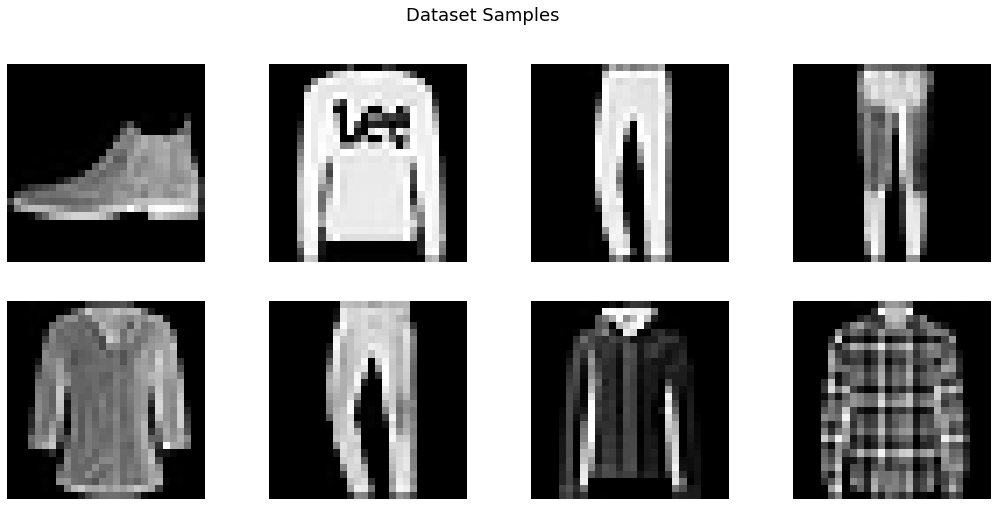

In [ ]:
# Download the MNIST dataset.
(X_train_in, y_train_in), (X_valid_in, y_valid_in) = get_data()

visualize_samples(X_valid_in, y_valid_in)

### 3.4 Preprocess the Dataset

In [ ]:
# Preprocess dataset.
((X_train, y_train),
(X_valid, y_valid)) = preprocess_dataset((X_train_in, y_train_in),
                                         (X_valid_in, y_valid_in),
                                         resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
                                         num_classes=DatasetConfig.NUM_CLASSES,
                                        )

There are 60000 training examples 
There are 10000 validation examples
Image data shape is (28, 28, 1)
There are 10 classes



X_train: (60000, 28, 28, 1), Y_train: (60000, 10)
X_valid: (10000, 28, 28, 1), Y_valid: (10000, 10)


## 4 LeNet5 Model

In [ ]:
def LeNet5_model(num_classes, shape, print_model_summary=True):

    inputs = Input(shape=shape)
    
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling 
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # ------------------------- 
    # Fully connected layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')
    
    if print_model_summary:
        model.summary()
        
    return model

## 5 Training Function

In [ ]:
def train_model(train_set,
                valid_set,
                optimizer,
                version_number,
                epochs=TrainingConfig.EPOCHS,
                print_model_summary=False,
               ):
    
    os.makedirs(TrainingConfig.ROOT_LOG_DIR, exist_ok=True)
    os.makedirs(TrainingConfig.ROOT_CHECKPOINT_DIR, exist_ok=True)

    folders = os.listdir(TrainingConfig.ROOT_LOG_DIR)

    if len(folders):
        last_version_number = int(sorted(folders)[-1].replace("version_", ""))
        version_number = last_version_number + 1

    log_dir = os.path.join(TrainingConfig.ROOT_LOG_DIR, f"version_{version_number}")
    checkpoint_dir = os.path.join(TrainingConfig.ROOT_CHECKPOINT_DIR, f"version_{version_number}")

    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")

    (X_train, y_train) = train_set
    (X_valid, y_valdi) = valid_set
    
    # Initialize the LeNet Model.
    model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES,
                         shape=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH, DatasetConfig.CHANNELS),
                         print_model_summary=print_model_summary,
                        )
    
    # Compile the model for the requested optimizer.
    if optimizer=="SGD":
        
        model.compile(tf.keras.optimizers.SGD(),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )
        
    elif optimizer=="SGD_m":
        
        model.compile(tf.keras.optimizers.SGD(momentum=0.9), 
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )
        
    elif optimizer=="RMSProp":
        
        model.compile(tf.keras.optimizers.RMSprop(),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )   
        
    elif optimizer=="Adam":
        
        model.compile(tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )
    else:
        
        print("Invalid optimizer: ", optimizer)
        exit()
        
    
    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=TrainingConfig.ROOT_LOG_DIR,
                                                          histogram_freq=0,
                                                          write_graph=True,
                                                          write_images=False,
                                                          write_steps_per_second=False,
                                                          update_freq="epoch",
                                                          profile_batch=2,
                                                          embeddings_freq=0,
                                                          embeddings_metadata=None,
                                                         )

    # Save best model depending on validation_accuracy.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.ROOT_CHECKPOINT_DIR,
                                                                   save_weights_only=False,
                                                                   monitor="val_accuracy",
                                                                   mode="max",
                                                                   save_best_only=True,
                                                                  )

    print(f"\nTraining for {epochs} epochs\n")
    
    results = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=TrainingConfig.BATCH_SIZE,
                        validation_data=(X_valid, y_valid),
                        callbacks=[tensorboard_callback, model_checkpoint_callback],
                       )

    return results, version_number

## 6 Training using SGD (Stochastic Gradient Desent)
Gradient descent update rule:

$$
W_t = W_{t-1} -\alpha g_{t-1}
$$

where,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

and,


$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n} 
         \end{bmatrix}
$$

For stochastic gradient descent update, we use the following method in TensorFlow:


```
tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD', **kwargs
)
```

- `learning_rate` – A Tensor, floating point value, or a schedule that is a `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable that takes no arguments and returns the actual value to use. The learning rate. Defaults to 0.01.

- `momentum` – float hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. Defaults to 0, i.e., vanilla gradient descent.

- `nesterov` – boolean. Whether to apply Nesterov momentum. Defaults to `False`.

- `name` – Optional name prefix for the operations created when applying gradients. Defaults to "SGD".

- `**kwargs` – Keyword arguments. Allowed to be one of "clipnorm" or "clipvalue". "clipnorm" (float) clips gradients by norm; "clipvalue" (float) clips gradients by value.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD" target=_blank>SGD Documentation</a>

In [ ]:
# Set the initial version number.
version_number = 0

# Train with SGD.
training_results_SGD, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   optimizer='SGD',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS, 
                                                   print_model_summary=True,
                                                  )

Logging at: optimizer_logs/version_0
Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 activation (Activation)     (None, 24, 24, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 activation_1 (Activation)   (None, 8, 8, 16)          0         
                       

## 7 Training using SGD with Momentum
Gradient descent with momentun update rule:

$$
\begin{align}
v_t &= \beta v_{t-1} + (1 - \beta) g_{t-1} \\
\\
W_t &= W_{t-1} - \alpha v_t \\
\end{align}
$$


In TensorFlow, we use `tf.keras.optimizers.SGD` with non-zero momentum value.

In the following training, we will use $\beta = 0.9$. Here $\beta$ is momentum.


In [ ]:
# Train with SGD with Momentum.
training_results_SGD_m, version_number = train_model(train_set=(X_train, y_train),
                                                     valid_set=(X_valid, y_valid),
                                                     optimizer='SGD_m',
                                                     version_number=version_number,
                                                     epochs=TrainingConfig.EPOCHS, 
                                                     print_model_summary=False,
                                                    )

Logging at: optimizer_logs/version_1

Training for 101 epochs

Epoch 1/101
938/938 [==============================] - 5s 5ms/step - loss: 0.6436 - accuracy: 0.7648 - val_loss: 0.4678 - val_accuracy: 0.8329
Epoch 2/101
938/938 [==============================] - 5s 5ms/step - loss: 0.4103 - accuracy: 0.8504 - val_loss: 0.3991 - val_accuracy: 0.8548
Epoch 3/101
938/938 [==============================] - 4s 5ms/step - loss: 0.3574 - accuracy: 0.8672 - val_loss: 0.3701 - val_accuracy: 0.8652
Epoch 4/101
938/938 [==============================] - 5s 5ms/step - loss: 0.3267 - accuracy: 0.8779 - val_loss: 0.3604 - val_accuracy: 0.8691
Epoch 5/101
938/938 [==============================] - 5s 5ms/step - loss: 0.3098 - accuracy: 0.8840 - val_loss: 0.3366 - val_accuracy: 0.8761
Epoch 6/101
938/938 [==============================] - 5s 5ms/step - loss: 0.2910 - accuracy: 0.8918 - val_loss: 0.3268 - val_accuracy: 0.8831
Epoch 7/101
938/938 [==============================] - 4s 4ms/step - loss: 0.27

## 8 Training using RMSProp
RMSProp update rule:

$$
\begin{align}
s_t &= \beta s_{t-1} + (1 - \beta) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {g_{t-1}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

For RMSProp weight update, we use the following method in TensorFlow:

```
tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop', **kwargs
)
```
- `learning_rate` – A Tensor, floating point value, or a schedule that is a `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable that takes no arguments and returns the actual value to use. The learning rate. Defaults to 0.001.

- `rho` – Discounting factor for the history/coming gradient. Defaults to 0.9.

- `momentum` – A scalar or a scalar Tensor. Defaults to 0.0.

- `epsilon` – A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper. Defaults to 1e-7.

- `centered` – 	Boolean. If `True`, gradients are normalized by the estimated variance of the gradient; if False, by the uncentered second moment. Setting this to True may help with training, but is slightly more expensive in terms of computation and memory. Defaults to `False`.

- `name` – Optional name prefix for the operations created when applying gradients. Defaults to "`RMSprop`".

- `**kwargs` – Keyword arguments. Allowed to be one of "`clipnorm`" or "`clipvalue`". "`clipnorm`" (float) clips gradients by norm; "`clipvalue`" (float) clips gradients by value.



<a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop" target=_blank>RMSProp Documentation</a>

In [ ]:
# Train with RMSProp.
training_results_RMSProp, version_number = train_model(train_set=(X_train, y_train),
                                                       valid_set=(X_valid, y_valid),
                                                       optimizer='RMSProp',
                                                       version_number=version_number,
                                                       epochs=TrainingConfig.EPOCHS, 
                                                       print_model_summary=False,
                                                      )

Logging at: optimizer_logs/version_2

Training for 101 epochs

Epoch 1/101
938/938 [==============================] - 6s 6ms/step - loss: 0.6144 - accuracy: 0.7731 - val_loss: 0.5095 - val_accuracy: 0.8211
Epoch 2/101
938/938 [==============================] - 5s 5ms/step - loss: 0.3937 - accuracy: 0.8569 - val_loss: 0.3858 - val_accuracy: 0.8612
Epoch 3/101
938/938 [==============================] - 4s 5ms/step - loss: 0.3368 - accuracy: 0.8773 - val_loss: 0.3784 - val_accuracy: 0.8604
Epoch 4/101
938/938 [==============================] - 5s 5ms/step - loss: 0.3044 - accuracy: 0.8881 - val_loss: 0.3416 - val_accuracy: 0.8770
Epoch 5/101
938/938 [==============================] - 5s 5ms/step - loss: 0.2838 - accuracy: 0.8943 - val_loss: 0.3388 - val_accuracy: 0.8813
Epoch 6/101
938/938 [==============================] - 5s 6ms/step - loss: 0.2668 - accuracy: 0.9016 - val_loss: 0.3272 - val_accuracy: 0.8829
Epoch 7/101
938/938 [==============================] - 5s 5ms/step - loss: 0.25

## 9 Training using Adam (Momentum + RMSProp)

Adam update rule:
$$
\begin{align}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) g_{t-1} \\
\\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {v_{t}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

For Adam weight update, we use the following method in TensorFlow:

```
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam', **kwargs
)
```
- `learning_rate` – A Tensor, floating point value, or a schedule that is a `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable that takes no arguments and returns the actual value to use, The learning rate. Defaults to 0.001.

- `beta_1` – A float value or a constant float tensor, or a callable that takes no arguments and returns the actual value to use. The exponential decay rate for the 1st moment estimates. Defaults to 0.9.

- `beta_2` – A float value or a constant float tensor, or a callable that takes no arguments and returns the actual value to use, The exponential decay rate for the 2nd moment estimates. Defaults to 0.999.

- `epsilon` – A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper. Defaults to 1e-7.

- `amsgrad` – Boolean. Whether to apply AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and beyond". Defaults to `False`.

- `name` - Optional name for the operations created when applying gradients. Defaults to "Adam".

- `**kwargs` – Keyword arguments. Allowed to be one of "`clipnorm`" or "`clipvalue`". "`clipnorm`" (float) clips gradients by norm; "`clipvalue`" (float) clips gradients by value.


<a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam" target=_blank>Adam Documentation</a>

In [ ]:
# Train with Adam.
training_results_Adam, version_number = train_model(train_set=(X_train, y_train),
                                                    valid_set=(X_valid, y_valid),
                                                    optimizer='Adam',
                                                    version_number=version_number,
                                                    epochs=TrainingConfig.EPOCHS, 
                                                    print_model_summary=False,
                                                    )

Logging at: optimizer_logs/version_3

Training for 101 epochs

Epoch 1/101
938/938 [==============================] - 6s 6ms/step - loss: 0.5988 - accuracy: 0.7830 - val_loss: 0.4703 - val_accuracy: 0.8264
Epoch 2/101
938/938 [==============================] - 5s 5ms/step - loss: 0.4111 - accuracy: 0.8516 - val_loss: 0.4066 - val_accuracy: 0.8524
Epoch 3/101
938/938 [==============================] - 5s 5ms/step - loss: 0.3604 - accuracy: 0.8678 - val_loss: 0.3749 - val_accuracy: 0.8641
Epoch 4/101
938/938 [==============================] - 5s 5ms/step - loss: 0.3323 - accuracy: 0.8770 - val_loss: 0.3556 - val_accuracy: 0.8734
Epoch 5/101
938/938 [==============================] - 5s 5ms/step - loss: 0.3110 - accuracy: 0.8859 - val_loss: 0.3412 - val_accuracy: 0.8713
Epoch 6/101
938/938 [==============================] - 5s 5ms/step - loss: 0.2922 - accuracy: 0.8925 - val_loss: 0.3283 - val_accuracy: 0.8829
Epoch 7/101
938/938 [==============================] - 5s 5ms/step - loss: 0.27

## 10 Plot Loss Curves

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

### 10.1 Training Loss

When evaluating optimizers, it's important to study the **training** loss to understand the convergence behavior on the training data. Remember that for a given model and dataset, the job of the optimizer is to perform well on the training data. 

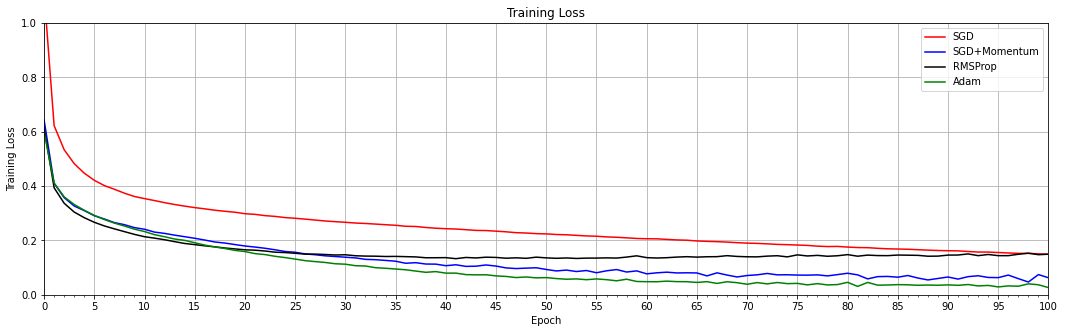

In [ ]:
train_loss_sgd      = training_results_SGD.history['loss']
train_loss_sgd_m    = training_results_SGD_m.history['loss']
train_loss_rms_prop = training_results_RMSProp.history['loss']
train_loss_adam     = training_results_Adam.history['loss']
 
plot_results([ train_loss_sgd, train_loss_sgd_m, train_loss_rms_prop, train_loss_adam ], 
            ylabel="Training Loss",
            ylim = [0.0, 1.0],
            metric_name=["SGD", "SGD+Momentum", "RMSProp", "Adam"],
            color=['r', 'b', 'k', 'g'])

As shown in the plot above, SGD (red) has the highest loss of the four optimizers, while Adam (green) eventually achieves the lowest loss. Also, notice that SGD+Momentum (blue) follows a very similar trend to Adam, though not quite as low. Initially, RMSProp (black) converges the fastest in the first 10-15 epochs, but if you look carefully, it starts diverging after about 40-50 epochs which is not desirable. So for this model and dataset, Adam clearly performs the best. But there are a couple of caveats. First, recall that in each case, we used the default learning rate for each optimizer, which is a good thing to do initially.

Once you have a baseline, you can adjust the learning rates for each optimizer to see how that affects the results. Another option is to adjust the learning rate during the training process programmatically by using a learning rate scheduler (we will cover this topic in a future notebook). There is often some experimentation required for selecting the "best" type of optimizer as well as tunning it. The main point here is that it's a good idea to try several optimizers initially. Although Adam generally performs very well under a wide range of conditions, it is not necessarily the best choice for all problems, and you should at least experiment initially to see which optimizer looks best. Once you select an optimizer, it is often required to experiment further to finetune the training of your model.

### 10.2 Validation Loss

Although we often study validation loss when training models, this should not be the criteria by which an optimizer is selected, since the optimizer's job is to achieve fast and stable convergence on the training data. However, it is worth studying the validation loss in this case to make a few points.

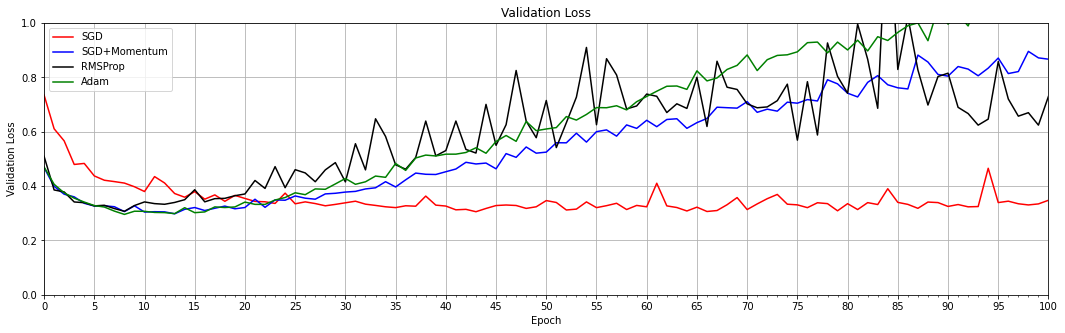

In [ ]:
val_loss_sgd      = training_results_SGD.history['val_loss']
val_loss_sgd_m    = training_results_SGD_m.history['val_loss']
val_loss_rms_prop = training_results_RMSProp.history['val_loss']
val_loss_adam     = training_results_Adam.history['val_loss']

plot_results([ val_loss_sgd, val_loss_sgd_m, val_loss_rms_prop, val_loss_adam ], 
            ylabel="Validation Loss",
            ylim = [0.0, 1.0],
            metric_name=["SGD", "SGD+Momentum", "RMSProp", "Adam"],
            color=['r', 'b', 'k', 'g'])

In the plot above, we first notice that loss for three optimizers start diverging after about 10-15 epochs. The SGD optimizer takes longer to converge but flattens out and does not really appear to diverge. So it can be tempting to conclude that SGD might be a good choice. But again, we need to remember that while validation loss is important for fine-tuning model and hyperparameters for a given optimizer, this should not be the criteria by which an optimizer is selected.

But if you compare these curves carefully, you will see that Adam, SGD+Momentum, and RMSProp all achieve about the same minimum (validation) loss somewhere between 8 and 15 epochs which all have a lower loss than the SGD (red) optimizer, which takes much longer to reach its minimum value. So although we don't want to use validation loss as criteria for selecting the **type** of optimizer to use, the fact that the other three optimizers achieve a lower loss than SGD in just a few epochs is a good indication that they have better convergence properties than SGD.

## 11 Conclusion

The main takeaway from this notebook is that it is worth studying the convergence properties of several optimizers to determine which one might be best suited for your problem. And the most important point to remember is that this comparison should be performed on the training dataset. Initially, it's recommended that the default learning rate for each optimizer be used to establish a baseline as opposed to the same learning rate for each optimizer because each optimizer works differently internally. After an initial assessment, as we have done here, you may decide to experiment further with the learning rates to help inform you which optimizer might be best.